In [1]:
import pandas as pd
from pathlib import Path
import re
import sympy
from datetime import datetime
import os

In [2]:
# Helper function: str to sympy
def string_to_sympy_odes(ode_string):
    """Convert string representation of ODEs to actual SymPy objects - works with ANY symbols."""

    # Extract the code between 'odes = [' and ']'
    match = re.search(r'odes\s*=\s*\[(.*?)\]', ode_string, re.DOTALL)
    if not match:
        raise ValueError("Could not find 'odes = [...]' pattern")
    
    content = match.group(1)
    
    # Find all unique symbols in the string
    # Functions: anything followed by (t)
    function_names = set(re.findall(r'(\w+)(?=\(t\))', content))
    
    # Parameters: all other word tokens that aren't Python/SymPy keywords
    all_tokens = set(re.findall(r'\b[a-zA-Z_]\w*\b', content))
    keywords = {'sympy', 'Eq', 'diff', 't', 'import', 'def', 'class', 'None', 'True', 'False'}
    parameter_names = all_tokens - function_names - keywords
    
    # Build namespace
    namespace = {
        'sympy': sympy,
        'Eq': sympy.Eq,
        't': sympy.Symbol('t')
    }
    
    # Create all functions
    for fname in function_names:
        namespace[fname] = sympy.Function(fname)
    
    # Create all parameters
    for pname in parameter_names:
        namespace[pname] = sympy.Symbol(pname)
    
    code = f"odes = [{content}]"
    exec(code, namespace)
    
    return namespace['odes']

In [3]:
# Helper function: function notation with (t) 

def convert_to_function_notation(equations):
    """Convert Derivative(S, t) to Derivative(S(t), t) in equations"""
    t = sympy.Symbol('t')

    result = []
    for eq in equations:
        # Fix the left-hand side
        if isinstance(eq.lhs, sympy.Derivative):
            var = eq.lhs.args[0]  # This is S, E, etc.
            if isinstance(var, sympy.Symbol):
                func_name = str(var)
                func = sympy.Function(func_name)
                new_lhs = sympy.Derivative(func(t), t)
            else:
                new_lhs = eq.lhs
        else:
            new_lhs = eq.lhs
        
        # Fix the right-hand side
        state_vars = ['S', 'E', 'I', 'P', 'A', 'H', 'R', 'F']
        subs_dict = {}
        for var_name in state_vars:
            var = sympy.Symbol(var_name)
            if var in eq.rhs.free_symbols:
                func = sympy.Function(var_name)
                subs_dict[var] = func(t)
        
        new_rhs = eq.rhs.subs(subs_dict)
        result.append(sympy.Eq(new_lhs, new_rhs))
    
    return result

In [4]:
# Helper function: sort equations by LHS

def sort_equations_by_lhs(equations):
    """Sort equations by the variable letter in the LHS derivative"""
    import re
    
    def get_lhs_variable(eq):
        lhs_str = str(eq.lhs)
        # Handle Derivative(S(t), t) or Derivative(S, t) format
        match = re.search(r'Derivative\(([A-Z])(?:\(t\))?,', lhs_str)
        if match:
            return match.group(1)
        # Fallback: look for any single letter variable
        match = re.search(r'([AEFHIPRS])', lhs_str)
        if match:
            return match.group(1)
        return 'Z'
    
    return sorted(equations, key=get_lhs_variable)

#### AI setup

In [5]:
# check API key
import os

api_key = os.environ.get("OPENAI_API_KEY")
if api_key:
    print("API key is set")
else:
    print("API key not found in environment variables")

API key is set


In [6]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes, image_file_to_odes_str
client = OpenAIClient()

#### Extraction: image -> str

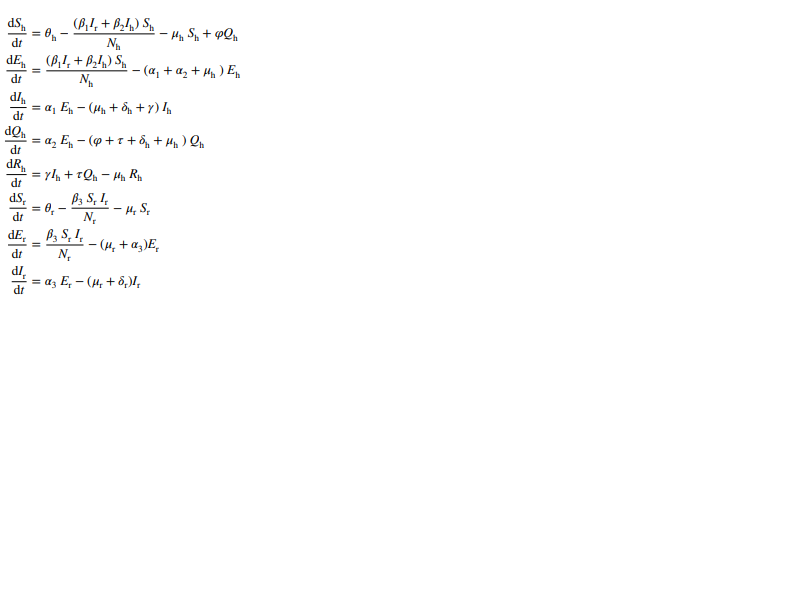

In [101]:
# Extract ODEs from image

biomodel_name = "2024_dec_epi_1_model_B"

from IPython.display import Image
image_path = f'images/{biomodel_name}.png'
Image(image_path)

In [102]:
ode_str = image_file_to_odes_str(image_path, client=client)
print(ode_str)
# Note that the LLM sometimes misses to define one of the parameters. When this happens, a human-in-the-loop can quickly edit the output

INFO: [2025-09-08 15:04:17] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
Sh, Eh, Ih, Qh, Rh, St, It, Et, Rt = sympy.symbols("Sh Eh Ih Qh Rh St It Et Rt", cls=sympy.Function)

# Define the parameters
alpha_1, alpha_2, alpha_3, beta_1, beta_2, mu_h, mu_t, phi, gamma_h = sympy.symbols("alpha_1 alpha_2 alpha_3 beta_1 beta_2 mu_h mu_t phi gamma_h")
N_h, N_t = sympy.symbols("N_h N_t")

odes = [
    sympy.Eq(Sh(t).diff(t), (beta_1 * It(t) + beta_2 * Ih(t)) / N_h - mu_h * Sh(t) + phi * Qh(t)),
    sympy.Eq(Eh(t).diff(t), (alpha_1 * (It(t) + beta_1 * Ih(t)) / N_h) - (alpha_1 + alpha_2 + mu_h) * Eh(t)),
    sympy.Eq(Ih(t).diff(t), alpha_2 * Eh(t) - (phi + gamma_h + mu_h) * Qh(t)),
    sympy.Eq(Qh(t).diff(t), gamma_h * Rh(t) - mu_h * Qh(t)),
    sympy.Eq(St(t).diff(t), - beta_2 * St(t) * It(t) / N_t + mu_t * St(t)),
    sympy.Eq(Et(t).diff(t), (beta_2 * St(t) * It(t)) / N_t - (mu_t + alpha_3) * Et(t)),
    sympy.Eq(Ih(t).diff(t), alpha_3 * Et(t) - mu_t * It(t)),
    symp

#### Corrected ODES, Corrected Concepts and Template Model from ode_str

In [103]:
# Use 2-step iteration process to check errors in the ode_str and get the corrected versions
# Get a template model from the extracted ODE str and send the ODE system in for attempting to ground each compartment
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes

tm, corrected_ode_str, corrected_concepts = execute_template_model_from_sympy_odes(
    ode_str=ode_str,
    attempt_grounding=True,
    client=client,
    use_multi_agent=True,
    return_corrected=True
)

INFO: [2025-09-08 15:04:22] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Running multi-agent validation...


INFO: [2025-09-08 15:04:39] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 1: Found errors: {'execution_errors': ["TypeError: 'Symbol' object is not callable - Ih, It, and others need to be defined as Functions instead of Symbols"], 'parameter_errors': [], 'time_dependency_errors': [], 'concept_errors': ['Ih, It, Rt need to be defined as sympy.Functions in the code.']}
Response keys: dict_keys(['has_errors', 'errors', 'auto_fixes_applied', 'corrected_code', 'corrected_concepts', 'confidence', 'manual_review_needed'])
corrected_code exists
corrected_code field exists, length: 1035
Type of corrected_concepts from JSON: <class 'dict'>
Content: {'Sh': {'identifiers': {'ido': '0000514'}, 'context': {'severity': 'high', 'species': 'ncbitaxon:9606'}}, 'Eh': {'identifiers': {'apollosv': '00000154'}, 'context': {'species': 'ncbitaxon:9606'}}, 'Ih': {'identifiers': {'ido': '0000511'}, 'context': {'stage': 'symptomatic', 'species': 'ncbitaxon:9606'}}, 'Qh': {'identifiers': {'ido': '0000592'}, 'context': {'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:

INFO: [2025-09-08 15:04:58] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 2: Found errors: {'execution_errors': [], 'parameter_errors': [], 'time_dependency_errors': [], 'concept_errors': []}
Response keys: dict_keys(['has_errors', 'errors', 'auto_fixes_applied', 'corrected_code', 'corrected_concepts', 'confidence', 'manual_review_needed'])
corrected_code exists
corrected_code field exists, length: 1186
Type of corrected_concepts from JSON: <class 'dict'>
Content: {'Sh': {'identifiers': {'ido': '0000514'}, 'context': {'severity': 'high', 'species': 'ncbitaxon:9606'}}, 'Eh': {'identifiers': {'apollosv': '00000154'}, 'context': {'species': 'ncbitaxon:9606'}}, 'Ih': {'identifiers': {'ido': '0000511'}, 'context': {'stage': 'symptomatic', 'species': 'ncbitaxon:9606'}}, 'Qh': {'identifiers': {'ido': '0000592'}, 'context': {'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}}, 'St': {'identifiers': {'ido': '0000514'}, 'context': {'species': 'ncbitaxon:9989'}}, 'Et': {'identifiers': {'apollosv': '00000154'}, 'context': {'species': 'ncbitaxon:998

INFO: [2025-09-08 15:05:15] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Iteration 3: Found errors: {'execution_errors': [], 'parameter_errors': [], 'time_dependency_errors': [], 'concept_errors': []}
Response keys: dict_keys(['has_errors', 'errors', 'auto_fixes_applied', 'corrected_code', 'corrected_concepts', 'confidence', 'manual_review_needed'])
corrected_code exists
corrected_code field exists, length: 1186
Type of corrected_concepts from JSON: <class 'dict'>
Content: {'Sh': {'identifiers': {'ido': '0000514'}, 'context': {'severity': 'high', 'species': 'ncbitaxon:9606'}}, 'Eh': {'identifiers': {'apollosv': '00000154'}, 'context': {'species': 'ncbitaxon:9606'}}, 'Ih': {'identifiers': {'ido': '0000511'}, 'context': {'stage': 'symptomatic', 'species': 'ncbitaxon:9606'}}, 'Qh': {'identifiers': {'ido': '0000592'}, 'context': {'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}}, 'St': {'identifiers': {'ido': '0000514'}, 'context': {'species': 'ncbitaxon:9989'}}, 'Et': {'identifiers': {'apollosv': '00000154'}, 'context': {'species': 'ncbitaxon:998

In [104]:
print(corrected_ode_str)

corrected_odes_sympy = string_to_sympy_odes(corrected_ode_str)

corrected_odes_sympy

import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
Sh, Eh, Ih, Qh, Rh, St, It, Et, Rt = sympy.Function('Sh'), sympy.Function('Eh'), sympy.Function('Ih'), sympy.Function('Qh'), sympy.Function('Rh'), sympy.Function('St'), sympy.Function('It'), sympy.Function('Et'), sympy.Function('Rt')

# Define the parameters
alpha_1, alpha_2, alpha_3, beta_1, beta_2, mu_h, mu_t, phi, gamma_h = sympy.symbols("alpha_1 alpha_2 alpha_3 beta_1 beta_2 mu_h mu_t phi gamma_h")
N_h, N_t = sympy.symbols("N_h N_t")

odes = [
    sympy.Eq(Sh(t).diff(t), (beta_1 * It(t) + beta_2 * Ih(t)) / N_h - mu_h * Sh(t) + phi * Qh(t)),
    sympy.Eq(Eh(t).diff(t), (alpha_1 * (It(t) + beta_1 * Ih(t)) / N_h) - (alpha_1 + alpha_2 + mu_h) * Eh(t)),
    sympy.Eq(Ih(t).diff(t), alpha_2 * Eh(t) - (phi + gamma_h + mu_h) * Qh(t)),
    sympy.Eq(Qh(t).diff(t), gamma_h * Rh(t) - mu_h * Qh(t)),
    sympy.Eq(St(t).diff(t), - beta_2 * St(t) * It(t) / N_t + mu_t * St(t)),
    sympy.Eq(Et(t).diff(

[Eq(Derivative(Sh(t), t), -mu_h*Sh(t) + phi*Qh(t) + (beta_1*It(t) + beta_2*Ih(t))/N_h),
 Eq(Derivative(Eh(t), t), -(alpha_1 + alpha_2 + mu_h)*Eh(t) + alpha_1*(beta_1*Ih(t) + It(t))/N_h),
 Eq(Derivative(Ih(t), t), alpha_2*Eh(t) - (gamma_h + mu_h + phi)*Qh(t)),
 Eq(Derivative(Qh(t), t), gamma_h*Rh(t) - mu_h*Qh(t)),
 Eq(Derivative(St(t), t), mu_t*St(t) - beta_2*It(t)*St(t)/N_t),
 Eq(Derivative(Et(t), t), -(alpha_3 + mu_t)*Et(t) + beta_2*It(t)*St(t)/N_t),
 Eq(Derivative(It(t), t), alpha_3*Et(t) - mu_t*It(t)),
 Eq(Derivative(Rt(t), t), alpha_3*Et(t) - mu_t*Rt(t))]

In [105]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
mtx_sympy = om.get_interpretable_kinetics()

mtx_odes_sympy = []
for i in range(mtx_sympy.shape[0]):
    lhs = mtx_sympy[i,0]
    rhs = mtx_sympy[i,2]
    mtx_odes_sympy.append(sympy.Eq(lhs, rhs))

print(mtx_sympy)
print(mtx_odes_sympy)
mtx_sympy


Matrix([[Derivative(Et, t), =, -Et*(alpha_3 + mu_t) + It*St*beta_2/N_t], [Derivative(It, t), =, Et*alpha_3 - It*mu_t], [Derivative(Rt, t), =, Et*alpha_3 - Rt*mu_t], [Derivative(Qh, t), =, -Qh*mu_h + gamma_h*Rh(t)], [Derivative(Sh, t), =, Qh*phi - Sh*mu_h + (Ih*beta_2 + It*beta_1)/N_h], [Derivative(Eh, t), =, -Eh*(alpha_1 + alpha_2 + mu_h) + alpha_1*(Ih*beta_1 + It)/N_h], [Derivative(Ih, t), =, Eh*alpha_2 - Qh*(gamma_h + mu_h + phi)], [Derivative(St, t), =, -It*St*beta_2/N_t + St*mu_t]])
[Eq(Derivative(Et, t), -Et*(alpha_3 + mu_t) + It*St*beta_2/N_t), Eq(Derivative(It, t), Et*alpha_3 - It*mu_t), Eq(Derivative(Rt, t), Et*alpha_3 - Rt*mu_t), Eq(Derivative(Qh, t), -Qh*mu_h + gamma_h*Rh(t)), Eq(Derivative(Sh, t), Qh*phi - Sh*mu_h + (Ih*beta_2 + It*beta_1)/N_h), Eq(Derivative(Eh, t), -Eh*(alpha_1 + alpha_2 + mu_h) + alpha_1*(Ih*beta_1 + It)/N_h), Eq(Derivative(Ih, t), Eh*alpha_2 - Qh*(gamma_h + mu_h + phi)), Eq(Derivative(St, t), -It*St*beta_2/N_t + St*mu_t)]


Matrix([
[Derivative(Et, t), =,                       -Et*(alpha_3 + mu_t) + It*St*beta_2/N_t],
[Derivative(It, t), =,                                          Et*alpha_3 - It*mu_t],
[Derivative(Rt, t), =,                                          Et*alpha_3 - Rt*mu_t],
[Derivative(Qh, t), =,                                      -Qh*mu_h + gamma_h*Rh(t)],
[Derivative(Sh, t), =,                Qh*phi - Sh*mu_h + (Ih*beta_2 + It*beta_1)/N_h],
[Derivative(Eh, t), =, -Eh*(alpha_1 + alpha_2 + mu_h) + alpha_1*(Ih*beta_1 + It)/N_h],
[Derivative(Ih, t), =,                        Eh*alpha_2 - Qh*(gamma_h + mu_h + phi)],
[Derivative(St, t), =,                                   -It*St*beta_2/N_t + St*mu_t]])

In [106]:
mtx_odes_sympy = []
for i in range(mtx_sympy.shape[0]):
    lhs = mtx_sympy[i,0]
    rhs = mtx_sympy[i,2]
    mtx_odes_sympy.append(sympy.Eq(lhs, rhs))

mtx_odes_sympy = convert_to_function_notation(mtx_odes_sympy)
mtx_odes_sympy

[Eq(Derivative(Et(t), t), -Et*(alpha_3 + mu_t) + It*St*beta_2/N_t),
 Eq(Derivative(It(t), t), Et*alpha_3 - It*mu_t),
 Eq(Derivative(Rt(t), t), Et*alpha_3 - Rt*mu_t),
 Eq(Derivative(Qh(t), t), -Qh*mu_h + gamma_h*Rh(t)),
 Eq(Derivative(Sh(t), t), Qh*phi - Sh*mu_h + (Ih*beta_2 + It*beta_1)/N_h),
 Eq(Derivative(Eh(t), t), -Eh*(alpha_1 + alpha_2 + mu_h) + alpha_1*(Ih*beta_1 + It)/N_h),
 Eq(Derivative(Ih(t), t), Eh*alpha_2 - Qh*(gamma_h + mu_h + phi)),
 Eq(Derivative(St(t), t), -It*St*beta_2/N_t + St*mu_t)]

In [107]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
It	{'ido': '0000511'}	{'species': 'ncbitaxon:9989'}
Et	{'apollosv': '00000154'}	{'species': 'ncbitaxon:9989'}
Rt	{'ido': '0000592'}	{'species': 'ncbitaxon:9989'}
Sh	{'ido': '0000514'}	{'severity': 'high', 'species': 'ncbitaxon:9606'}
Qh	{'ido': '0000592'}	{'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}
Ih	{'ido': '0000511'}	{'stage': 'symptomatic', 'species': 'ncbitaxon:9606'}
Eh	{'apollosv': '00000154'}	{'species': 'ncbitaxon:9606'}
St	{'ido': '0000514'}	{'species': 'ncbitaxon:9989'}


#### String comparison of the correct and the extracted odes 

In [108]:
# Correct string (maunally extracted list)
file_path = '/Users/kovacs.f/Desktop/mira/notebooks/equation extraction development/extraction error check/string mismatch check/correct_eqs_list.tsv'

df = pd.read_csv(file_path, sep='\t')
try:
    correct_str = df[df['model'] == biomodel_name]['correct_eqs'].iloc[0]
except IndexError:
    raise ValueError(f"No correct equations found for model '{biomodel_name}' in {file_path}")

print(correct_str)

odes = [
    sympy.Eq(sh(t).diff(t), beta_h - (beta_1 * ir(t) + beta_2 * ih(t)) * sh(t) / N_h - mu_h * sh(t) + phi * qh(t)),
    sympy.Eq(eh(t).diff(t), (beta_1 * ir(t) + beta_2 * ih(t)) * sh(t) / N_h - (alpha_1 + alpha_2 + mu_h) * eh(t)),
    sympy.Eq(ih(t).diff(t), alpha_1 * eh(t) - (mu_h + delta_h + gamma) * ih(t)),
    sympy.Eq(qh(t).diff(t), alpha_2 * eh(t) - (phi + tau + delta_h + mu_h) * qh(t)),
    sympy.Eq(rh(t).diff(t), gamma * qh(t) + tau*qh(t) - mu_h * rh(t)),
    
    sympy.Eq(sr(t).diff(t), beta_r - (beta_3 * sr(t) * ir(t) / N_r) - mu_r*sr(t)),
    
    sympy.Eq(er(t).diff(t), beta_3 * sr(t) * ir(t) / N_r - (mu_r + alpha_3) * er(t)),
    sympy.Eq(ir(t).diff(t), alpha_3 * er(t) - (mu_r + delta_r) * ir(t))
]


In [109]:
# Trasforming correct_str to sympy eq
correct_odes_sympy = string_to_sympy_odes(correct_str)
correct_odes_sympy

[Eq(Derivative(sh(t), t), beta_h - mu_h*sh(t) + phi*qh(t) - (beta_1*ir(t) + beta_2*ih(t))*sh(t)/N_h),
 Eq(Derivative(eh(t), t), -(alpha_1 + alpha_2 + mu_h)*eh(t) + (beta_1*ir(t) + beta_2*ih(t))*sh(t)/N_h),
 Eq(Derivative(ih(t), t), alpha_1*eh(t) - (delta_h + gamma + mu_h)*ih(t)),
 Eq(Derivative(qh(t), t), alpha_2*eh(t) - (delta_h + mu_h + phi + tau)*qh(t)),
 Eq(Derivative(rh(t), t), gamma*qh(t) - mu_h*rh(t) + tau*qh(t)),
 Eq(Derivative(sr(t), t), beta_r - mu_r*sr(t) - beta_3*ir(t)*sr(t)/N_r),
 Eq(Derivative(er(t), t), -(alpha_3 + mu_r)*er(t) + beta_3*ir(t)*sr(t)/N_r),
 Eq(Derivative(ir(t), t), alpha_3*er(t) - (delta_r + mu_r)*ir(t))]

In [110]:
# Trasforming extracted_str to sympy eq
extracted_odes_sympy = string_to_sympy_odes(ode_str)
extracted_odes_sympy

[Eq(Derivative(Sh(t), t), -mu_h*Sh(t) + phi*Qh(t) + (beta_1*It(t) + beta_2*Ih(t))/N_h),
 Eq(Derivative(Eh(t), t), -(alpha_1 + alpha_2 + mu_h)*Eh(t) + alpha_1*(beta_1*Ih(t) + It(t))/N_h),
 Eq(Derivative(Ih(t), t), alpha_2*Eh(t) - (gamma_h + mu_h + phi)*Qh(t)),
 Eq(Derivative(Qh(t), t), gamma_h*Rh(t) - mu_h*Qh(t)),
 Eq(Derivative(St(t), t), mu_t*St(t) - beta_2*It(t)*St(t)/N_t),
 Eq(Derivative(Et(t), t), -(alpha_3 + mu_t)*Et(t) + beta_2*It(t)*St(t)/N_t),
 Eq(Derivative(Ih(t), t), alpha_3*Et(t) - mu_t*It(t)),
 Eq(Derivative(Rt(t), t), alpha_3*Et(t) - mu_t*Rt(t))]

In [111]:
# Displaying odes
print('Above-below comparison:')
print('Correct odes (extracted manually):')
print(correct_odes_sympy)
print('Extrated odes from the image:')
print(extracted_odes_sympy)
print('Checked and corrected odes:')
print(corrected_odes_sympy)
print('Matrix of odes extracted from TM:')
print(mtx_odes_sympy)

Above-below comparison:
Correct odes (extracted manually):
[Eq(Derivative(sh(t), t), beta_h - mu_h*sh(t) + phi*qh(t) - (beta_1*ir(t) + beta_2*ih(t))*sh(t)/N_h), Eq(Derivative(eh(t), t), -(alpha_1 + alpha_2 + mu_h)*eh(t) + (beta_1*ir(t) + beta_2*ih(t))*sh(t)/N_h), Eq(Derivative(ih(t), t), alpha_1*eh(t) - (delta_h + gamma + mu_h)*ih(t)), Eq(Derivative(qh(t), t), alpha_2*eh(t) - (delta_h + mu_h + phi + tau)*qh(t)), Eq(Derivative(rh(t), t), gamma*qh(t) - mu_h*rh(t) + tau*qh(t)), Eq(Derivative(sr(t), t), beta_r - mu_r*sr(t) - beta_3*ir(t)*sr(t)/N_r), Eq(Derivative(er(t), t), -(alpha_3 + mu_r)*er(t) + beta_3*ir(t)*sr(t)/N_r), Eq(Derivative(ir(t), t), alpha_3*er(t) - (delta_r + mu_r)*ir(t))]
Extrated odes from the image:
[Eq(Derivative(Sh(t), t), -mu_h*Sh(t) + phi*Qh(t) + (beta_1*It(t) + beta_2*Ih(t))/N_h), Eq(Derivative(Eh(t), t), -(alpha_1 + alpha_2 + mu_h)*Eh(t) + alpha_1*(beta_1*Ih(t) + It(t))/N_h), Eq(Derivative(Ih(t), t), alpha_2*Eh(t) - (gamma_h + mu_h + phi)*Qh(t)), Eq(Derivative(Qh(t

In [112]:
# Sort for comparison
correct_odes_sorted = sort_equations_by_lhs(correct_odes_sympy)
extracted_odes_sorted = sort_equations_by_lhs(extracted_odes_sympy)
corrected_odes_sorted = sort_equations_by_lhs(corrected_odes_sympy)
mtx_odes_sorted = sort_equations_by_lhs(mtx_odes_sympy)

In [113]:
# Comparison by substraction
# correct_odes vs. extracted_odes_sympy
diff_correct_extracted_odes = []
for eq1, eq2 in zip(correct_odes_sorted, extracted_odes_sorted):
    diff = sympy.simplify((eq1.lhs - eq1.rhs) - (eq2.lhs - eq2.rhs))
    diff_correct_extracted_odes.append(diff)

# correct_odes vs. corrected_odes_sympy
diff_correct_corrected_odes = []
for eq1, eq2 in zip(correct_odes_sorted, corrected_odes_sorted):
    diff = sympy.simplify((eq1.lhs - eq1.rhs) - (eq2.lhs - eq2.rhs))
    diff_correct_corrected_odes.append(diff)

# correct_odes vs. mtx_odes_sympy
diff_correct_mtx_odes = []
for eq1, eq2 in zip(correct_odes_sorted, mtx_odes_sorted):
    diff = sympy.simplify((eq1.lhs - eq1.rhs) - (eq2.lhs - eq2.rhs))
    diff_correct_mtx_odes.append(diff)

In [114]:
# Save detailed comparison
def comparisons_to_md(
    correct_odes_sorted,
    extracted_odes_sorted,
    corrected_odes_sorted,
    mtx_odes_sorted,
    biomodel_name,
    folder_path="/Users/kovacs.f/Desktop/mira/notebooks/equation extraction development/extraction error check/string mismatch check/comparison_results_version002"
):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    os.makedirs(folder_path, exist_ok=True)
    file_path = os.path.join(folder_path, f"comparison_{biomodel_name}_odes.md")
    
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(f"\n# Comparison by Subtraction\n")
        f.write(f"## Model: {biomodel_name}\n")
        f.write(f"### Timestamp: {timestamp}\n\n")
        
        # 1. correct_odes vs extracted_odes 
        f.write("## 1. correct_odes vs extracted_odes_sympy\n\n")
        for i, (eq1, eq2) in enumerate(zip(correct_odes_sorted, extracted_odes_sorted)):
            f.write(f"**Equation {i}:**\n")
            f.write(f"- Correct:   `{eq1}`\n")
            f.write(f"- Extracted: `{eq2}`\n")
            diff = sympy.simplify((eq1.lhs - eq1.rhs) - (eq2.lhs - eq2.rhs))
            f.write(f"- Difference: `{diff}`\n\n")
        
        # 2. correct_odes vs corrected_odes
        f.write("## 2. correct_odes vs corrected_odes_sympy\n\n")
        for i, (eq1, eq2) in enumerate(zip(correct_odes_sorted, corrected_odes_sorted)):
            f.write(f"**Equation {i}:**\n")
            f.write(f"- Correct: `{eq1}`\n")
            f.write(f"- Corrected: `{eq2}`\n")
            diff = sympy.simplify((eq1.lhs - eq1.rhs) - (eq2.lhs - eq2.rhs))
            f.write(f"- Difference: `{diff}`\n\n")
        
        # 3. correct_odes vs mtx_odes 
        f.write("## 3. correct_odes vs mtx_odes_sympy\n\n")
        for i in range(min(len(mtx_odes_sorted), len(correct_odes_sorted))):
            eq_mtx = mtx_odes_sorted[i]  
            eq_correct = correct_odes_sorted[i] 
            f.write(f"**Equation {i}:**\n")
            f.write(f"- Correct: `{eq_correct}`\n")
            f.write(f"- Matrix:  `{eq_mtx}`\n")
            diff = sympy.simplify((eq_mtx.lhs - eq_mtx.rhs) - (eq_correct.lhs - eq_correct.rhs))
            f.write(f"- Difference: `{diff}`\n\n")

comparisons_to_md(
    correct_odes_sorted,
    extracted_odes_sorted,
    corrected_odes_sorted,
    mtx_odes_sorted,
    biomodel_name,
    folder_path='/Users/kovacs.f/Desktop/mira/notebooks/equation extraction development/extraction error check/string mismatch check/comparison_results_version002'
)